# 03-replication-analysis-fs6.ipynb

Using `ibs-brain` conda environment

Arvid Lundervold

Last updated: 2024-12-04


Replication analysis of the Skrobisz et al. paper (Diagnostics, 2022) based on FreeSurfer v 6.0.1  using<br>

- `Skrobisz2022_HC_IBS_cleaned.csv` derived from `Skrobisz2022_diagnostics-12-02199-suppl_140x5.csv`

- `fs6_aseg_stats_for_regions_in_Skrobisz2022_78x38.csv` derived from _aseg.stats_ files.


NOTE: Ideally we should like to compute e.g., the generalized Mahalanobis distance between the two groups BS and HC in each cohort Skrobisz2022 and Bergen to explore the same ability for discriminating between the two groups. However, the key issue is that the covariance matrix S cannot be fully constructed without knowing the correlations between features. The standard deviations only give us the diagonal elements of the covariance matrix, but we need the off-diagonal elements (covariances) to compute the true Mahalanobis distance.

In [1]:
import os
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

home = os.path.expanduser('~')
%matplotlib inline

In [2]:
if platform.system() == 'Darwin':
    print(f'OK, you are running on MacOS ({platform.version()})')
if platform.system() == 'Linux':
    print(f'OK, you are running on Linux ({platform.version()})')
if platform.system() == 'Windows':
    print(f'OK, but consider to install WSL for Windows10/11 since you are running on {platform.system()}')
    print('Check https://docs.microsoft.com/en-us/windows/wsl/install')

OK, you are running on MacOS (Darwin Kernel Version 24.1.0: Thu Oct 10 21:02:27 PDT 2024; root:xnu-11215.41.3~2/RELEASE_X86_64)


In [3]:
df_fs6_in_Skrobisz2022 = pd.read_csv('../data/fs6_aseg_stats_for_regions_in_Skrobisz2022_78x38.csv')
df_fs6_in_Skrobisz2022


,Subject,Group,eTIV,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,Left-Hippocampus,...,BrainSegVol,BrainSegVolNotVent,lhCortexVol,rhCortexVol,CortexVol,lhCerebralWhiteMatterVol,rhCerebralWhiteMatterVol,CerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol
0,BGA_046,IBS,1.656739e+06,15798.4,62485.1,8398.0,3977.2,5478.8,2141.4,5136.9,...,1328062.0,1300437.0,258949.929272,263251.114768,522201.044040,274908.295272,278458.480929,553366.776201,67355.0,716754.044040
1,BGA_047,IBS,1.298615e+06,11829.9,55572.3,6954.8,2730.6,3744.3,1655.3,3951.3,...,1077449.0,1057641.0,246489.920670,240230.000960,486719.921630,195441.183118,188217.177971,383658.361090,51589.0,651544.921630
2,BGA_048,IBS,1.292984e+06,13925.9,52554.0,7421.1,3399.6,5102.1,2010.3,4723.0,...,1056661.0,1038836.0,223573.051052,222593.790010,446166.841061,199159.828471,200072.966734,399232.795205,60160.0,612686.841061
3,BGA_050,IBS,1.633022e+06,17741.3,48855.0,8278.9,3841.4,5198.3,2156.4,4562.7,...,1291667.0,1272599.0,261386.266251,262864.586632,524250.852883,274652.166574,276260.434358,550912.600932,64327.0,689174.852883
4,BGA_051,IBS,1.573626e+06,15380.1,57807.7,8299.9,3457.9,5190.6,2135.0,4659.2,...,1277079.0,1262046.0,262825.708782,259604.577045,522430.285827,263318.803712,262565.956089,525884.759802,62723.0,706788.285827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,BGA_166,HC,1.354683e+06,15492.9,49468.8,8071.5,3059.4,4228.4,1779.2,3872.2,...,1113783.0,1090811.0,245585.967094,243147.205361,488733.172455,208134.059290,208671.649416,416805.708707,55815.0,644921.172455
74,BGA_167,HC,1.352272e+06,15464.9,45437.7,7466.2,2834.5,4089.7,1694.3,3782.4,...,1045968.0,1023044.0,221197.829159,220734.192652,441932.021810,204370.518569,202097.857273,406468.375842,52832.0,588406.021810
75,BGA_168,HC,1.598696e+06,14630.0,54099.4,7640.3,3760.9,4792.9,1997.3,3926.4,...,1193455.0,1172525.0,249251.106723,249392.552845,498643.659568,235556.076141,237046.577269,472602.653410,58868.0,670004.659568
76,BGA_171,HC,1.559106e+06,14884.5,67731.3,8589.4,3731.8,5839.0,2500.6,4781.4,...,1295071.0,1280053.0,279914.091111,282386.426404,562300.517515,244827.405506,241897.905339,486725.310845,67793.0,765127.517515


In [4]:
df_Skrobisz2022 = pd.read_csv('../data/Skrobisz2022_HC_IBS_cleaned.csv')
df_Skrobisz2022

,Group,Region,N,Mean,SD
0,HC,Left-Cerebellum-White-Matter,19,0.009916,0.001128
1,HC,Left-Cerebellum-Cortex,19,0.036283,0.003024
2,HC,Left-Thalamus,19,0.005107,0.000373
3,HC,Left-Caudate,19,0.002388,0.000252
4,HC,Left-Putamen,19,0.003365,0.000326
...,...,...,...,...,...
65,IBS,lhCerebralWhiteMatterVol,20,0.150579,0.007418
66,IBS,rhCerebralWhiteMatterVol,20,0.150747,0.007270
67,IBS,CerebralWhiteMatterVol,20,0.301326,0.014613
68,IBS,SubCortGrayVol,20,0.038550,0.001617


In [5]:
# From df_fs6_in_Skrobisz2022, make eTIV-normalized Mean and SD values for the regions in df_Skrobisz2022 for HC and IBS, respectively

# First, normalize volumes by eTIV for each subject
df_normalized = df_fs6_in_Skrobisz2022.copy()
eTIV_values = df_normalized['eTIV']

# Normalize all columns except 'Subject', 'Group', and 'eTIV'
for col in df_normalized.columns:
    if col not in ['Subject', 'Group', 'eTIV']:
        df_normalized[col] = df_normalized[col] / eTIV_values

# Calculate mean and SD for each group
results = []
for group in ['HC', 'IBS']:
    group_data = df_normalized[df_normalized['Group'] == group]
    
    # Calculate mean and SD for each region
    for region in df_Skrobisz2022['Region'].unique():
        if region in df_normalized.columns:
            mean_val = group_data[region].mean()
            sd_val = group_data[region].std()
            
            results.append({
                'Group': group,
                'Region': region,
                'N': len(group_data),
                'Mean': mean_val,
                'SD': sd_val
            })

# Convert results to DataFrame
df_results = pd.DataFrame(results)

# Display results
print("eTIV-normalized regional volumes in our sample of 78 subjects:")
df_results

# Optional: Save to CSV
# df_results.to_csv('../data/normalized_volumes_comparison_fs6.csv', index=False)

eTIV-normalized regional volumes in our sample of 78 subjects:


,Group,Region,N,Mean,SD
0,HC,Left-Cerebellum-White-Matter,29,0.010496,0.000915
1,HC,Left-Cerebellum-Cortex,29,0.038939,0.003435
2,HC,Left-Thalamus,29,0.005232,0.000464
3,HC,Left-Caudate,29,0.002356,0.000259
4,HC,Left-Putamen,29,0.003479,0.000385
...,...,...,...,...,...
65,IBS,lhCerebralWhiteMatterVol,49,0.159148,0.008757
66,IBS,rhCerebralWhiteMatterVol,49,0.158267,0.009384
67,IBS,CerebralWhiteMatterVol,49,0.317415,0.018079
68,IBS,SubCortGrayVol,49,0.040629,0.002364


In [6]:
list(df_Skrobisz2022['Region'].unique())


['Left-Cerebellum-White-Matter',
 'Left-Cerebellum-Cortex',
 'Left-Thalamus',
 'Left-Caudate',
 'Left-Putamen',
 'Left-Pallidum',
 'Left-Hippocampus',
 'Left-Amygdala',
 'Left-Accumbens-area',
 'CSF',
 'Right-Cerebellum-White-Matter',
 'Right-Cerebellum-Cortex',
 'Right-Thalamus',
 'Right-Caudate',
 'Right-Putamen',
 'Right-Pallidum',
 'Right-Hippocampus',
 'Right-Amygdala',
 'Right-Accumbens-area',
 'WM-hypointensities',
 'CC_Posterior',
 'CC_Mid_Posterior',
 'CC_Central',
 'CC_Mid_Anterior',
 'CC_Anterior',
 'BrainSegVol',
 'BrainSegVolNotVent',
 'lhCortexVol',
 'rhCortexVol',
 'CortexVol',
 'lhCerebralWhiteMatterVol',
 'rhCerebralWhiteMatterVol',
 'CerebralWhiteMatterVol',
 'SubCortGrayVol',
 'TotalGrayVol']

In [7]:
# Make a table that compares our results with the results from Skrobisz et al.

# Create comparison table
regions_to_compare = [
'Left-Cerebellum-White-Matter',
 'Left-Cerebellum-Cortex',
 'Left-Thalamus',
 'Left-Caudate',
 'Left-Putamen',
 'Left-Pallidum',
 'Left-Hippocampus',
 'Left-Amygdala',
 'Left-Accumbens-area',
 'CSF',
 'Right-Cerebellum-White-Matter',
 'Right-Cerebellum-Cortex',
 'Right-Thalamus',
 'Right-Caudate',
 'Right-Putamen',
 'Right-Pallidum',
 'Right-Hippocampus',
 'Right-Amygdala',
 'Right-Accumbens-area',
 'WM-hypointensities',
 'CC_Posterior',
 'CC_Mid_Posterior',
 'CC_Central',
 'CC_Mid_Anterior',
 'CC_Anterior',
 'BrainSegVol',
 'BrainSegVolNotVent',
 'lhCortexVol',
 'rhCortexVol',
 'CortexVol',
 'lhCerebralWhiteMatterVol',
 'rhCerebralWhiteMatterVol',
 'CerebralWhiteMatterVol',
 'SubCortGrayVol',
 'TotalGrayVol'
]

# Initialize empty lists to store rows
comparison_rows = []

# For each region, get values from both datasets
for region in regions_to_compare:
    row = {'Brain Region': region}
    
    # Get Skrobisz2022 values
    skrobisz_hc = df_Skrobisz2022[df_Skrobisz2022['Group'] == 'HC']
    skrobisz_ibs = df_Skrobisz2022[df_Skrobisz2022['Group'] == 'IBS']
    
    # Get our FS6.0.1 values
    fs6_hc = df_results[df_results['Group'] == 'HC']
    fs6_ibs = df_results[df_results['Group'] == 'IBS']
    
    # Add values for each dataset and group
    for df_group, prefix in [(skrobisz_hc, 'Skrobisz HC'), 
                            (skrobisz_ibs, 'Skrobisz IBS'),
                            (fs6_hc, 'Bergen FS6.0.1 HC'),
                            (fs6_ibs, 'Bergen FS6.0.1 IBS')]:
        
        group_data = df_group[df_group['Region'] == region]
        if not group_data.empty:
            row[f'{prefix} Mean'] = f"{group_data['Mean'].iloc[0]:.6f}"
            row[f'{prefix} SD'] = f"{group_data['SD'].iloc[0]:.6f}"
    
    comparison_rows.append(row)

# Create DataFrame
comparison_df = pd.DataFrame(comparison_rows)

# Set display format
pd.set_option('display.float_format', lambda x: '%.6f' % x)

# Display the comparison table
print("\nComparison of Skrobisz 2022 and Bergen FS6.0.1 results:")
print(comparison_df.to_string(index=False))

# Optionally save to CSV
# comparison_df.to_csv('comparison_table.csv', index=False)


Comparison of Skrobisz 2022 and Bergen FS6.0.1 results:
                 Brain Region Skrobisz HC Mean Skrobisz HC SD Skrobisz IBS Mean Skrobisz IBS SD Bergen FS6.0.1 HC Mean Bergen FS6.0.1 HC SD Bergen FS6.0.1 IBS Mean Bergen FS6.0.1 IBS SD
 Left-Cerebellum-White-Matter         0.009916       0.001128          0.009708        0.001066               0.010496             0.000915                0.010483              0.000924
       Left-Cerebellum-Cortex         0.036283       0.003024          0.035530        0.002561               0.038939             0.003435                0.039314              0.003733
                Left-Thalamus         0.005107       0.000373          0.004996        0.000240               0.005232             0.000464                0.005144              0.000393
                 Left-Caudate         0.002388       0.000252          0.002278        0.000211               0.002356             0.000259                0.002355              0.000306
             

In [8]:
# Make this table in latex with a similar format as in the the following file:

def create_latex_table(df_skrobisz, df_bergen):
    """Create LaTeX table comparing Skrobisz and Bergen cohorts."""
    
    latex_str = [
        "\\begin{table}[htbp]",
        "\\centering",
        "\\caption{Comparison of normalized regional brain volumes between cohorts}",
        "\\begin{tabular}{lcccc}",
        "\\hline",
        " & \\multicolumn{2}{c}{Skrobisz Cohort (FS 6.0)} & \\multicolumn{2}{c}{Bergen Cohort (FS 6.0.1)} \\\\",
        "\\cline{2-3} \\cline{4-5}",
        "Brain Region & HC (N=19) & IBS (N=20) & HC (N=29) & IBS (N=49) \\\\",
        "\\hline"
    ]
    
    # Function to format mean and SD
    def format_mean_sd(mean, sd):
        return f"{mean:.5f} & {sd:.5f}"
    
    # Add each region's data
    for region in df_skrobisz['Region'].unique():
        if region in df_bergen.columns:
            # Get Skrobisz data
            skr_hc = df_skrobisz[(df_skrobisz['Group'] == 'HC') & (df_skrobisz['Region'] == region)]
            skr_ibs = df_skrobisz[(df_skrobisz['Group'] == 'IBS') & (df_skrobisz['Region'] == region)]
            
            # Get Bergen data
            berg_hc = df_bergen[df_bergen['Group'] == 'HC'][region]
            berg_ibs = df_bergen[df_bergen['Group'] == 'IBS'][region]
            
            # Format line
            line = f"{region} & "
            line += format_mean_sd(skr_hc['Mean'].iloc[0], skr_hc['SD'].iloc[0]) + " & "
            line += format_mean_sd(skr_ibs['Mean'].iloc[0], skr_ibs['SD'].iloc[0]) + " & "
            line += format_mean_sd(berg_hc.mean(), berg_hc.std()) + " & "
            line += format_mean_sd(berg_ibs.mean(), berg_ibs.std()) + " \\\\"
            
            latex_str.append(line)
    
    # Add table footer
    latex_str.extend([
        "\\hline",
        "\\multicolumn{5}{l}{\\footnotesize HC = Healthy Controls; IBS = Irritable Bowel Syndrome; SD = Standard Deviation.} \\\\",
        "\\multicolumn{5}{l}{\\footnotesize All volumes are normalized to estimated total intracranial volume.} \\\\",
        "\\end{tabular}",
        "\\label{tab:volume_comparison}",
        "\\end{table}"
    ])
    
    return '\n'.join(latex_str)

# Create the table
latex_table = create_latex_table(df_Skrobisz2022, df_normalized)

# Print the LaTeX code
print(latex_table)

# Optionally save to file
with open('../latex/tables/volume_Skrobisz2022_BergenFS6_comparison_table.tex', 'w') as f:
    f.write(latex_table)

\begin{table}[htbp]
\centering
\caption{Comparison of normalized regional brain volumes between cohorts}
\begin{tabular}{lcccc}
\hline
 & \multicolumn{2}{c}{Skrobisz Cohort (FS 6.0)} & \multicolumn{2}{c}{Bergen Cohort (FS 6.0.1)} \\
\cline{2-3} \cline{4-5}
Brain Region & HC (N=19) & IBS (N=20) & HC (N=29) & IBS (N=49) \\
\hline
Left-Cerebellum-White-Matter & 0.00992 & 0.00113 & 0.00971 & 0.00107 & 0.01050 & 0.00092 & 0.01048 & 0.00092 \\
Left-Cerebellum-Cortex & 0.03628 & 0.00302 & 0.03553 & 0.00256 & 0.03894 & 0.00344 & 0.03931 & 0.00373 \\
Left-Thalamus & 0.00511 & 0.00037 & 0.00500 & 0.00024 & 0.00523 & 0.00046 & 0.00514 & 0.00039 \\
Left-Caudate & 0.00239 & 0.00025 & 0.00228 & 0.00021 & 0.00236 & 0.00026 & 0.00236 & 0.00031 \\
Left-Putamen & 0.00336 & 0.00033 & 0.00324 & 0.00028 & 0.00348 & 0.00038 & 0.00344 & 0.00039 \\
Left-Pallidum & 0.00140 & 0.00012 & 0.00135 & 0.00010 & 0.00140 & 0.00015 & 0.00137 & 0.00011 \\
Left-Hippocampus & 0.00270 & 0.00021 & 0.00272 & 0.00020 & 0.00291

In [9]:
def create_latex_table(df_skrobisz, df_bergen):
    """Create LaTeX table comparing Skrobisz and Bergen cohorts with small font."""
    
    latex_str = [
        "\\begin{table}[H]",
        "\\setlength{\\tabcolsep}{5pt}",
        "\\centering",
        "\\footnotesize",  # Add small font size
        "\\caption{Comparison of normalized regional brain volumes between cohorts}",
        "\\begin{tabular}{lcccccccc}",
        "\\hline",
        " & \\multicolumn{4}{c}{Skrobisz Cohort (FS 6.0)} & \\multicolumn{4}{c}{Bergen Cohort (FS 6.0.1)} \\\\",
        "%\\cline{2-3} \\cline{4-5}",
        "Brain Region & \multicolumn{2}{c}{HC (N=19)} & \multicolumn{2}{c}{IBS (N=20)} & \multicolumn{2}{c}{HC (N=29)} & \multicolumn{2}{c}{IBS (N=49)} \\\\",
        "  & Mean & SD & Mean & SD & Mean & SD & Mean & SD \\\\"
        "\\hline"
    ]
    
    # Function to format mean and SD
    def format_mean_sd(mean, sd):
        return f"{mean:.6f} & {sd:.6f}"
    
    # Add each region's data
    for region in df_skrobisz['Region'].unique():
        if region in df_bergen.columns:
            # Get Skrobisz data
            skr_hc = df_skrobisz[(df_skrobisz['Group'] == 'HC') & (df_skrobisz['Region'] == region)]
            skr_ibs = df_skrobisz[(df_skrobisz['Group'] == 'IBS') & (df_skrobisz['Region'] == region)]
            
            # Get Bergen data
            berg_hc = df_bergen[df_bergen['Group'] == 'HC'][region]
            berg_ibs = df_bergen[df_bergen['Group'] == 'IBS'][region]
            
            # Format line
            line = f"{region} & "
            line += format_mean_sd(skr_hc['Mean'].iloc[0], skr_hc['SD'].iloc[0]) + " & "
            line += format_mean_sd(skr_ibs['Mean'].iloc[0], skr_ibs['SD'].iloc[0]) + " & "
            line += format_mean_sd(berg_hc.mean(), berg_hc.std()) + " & "
            line += format_mean_sd(berg_ibs.mean(), berg_ibs.std()) + " \\\\"
            
            latex_str.append(line)
    
    # Add table footer
    latex_str.extend([
        "\\hline",
        "\\multicolumn{9}{l}{\\footnotesize HC = Healthy Controls; IBS = Irritable Bowel Syndrome; SD = Standard Deviation.} \\\\",
        "\\multicolumn{9}{l}{\\footnotesize All volumes are normalized to estimated total intracranial volume.} \\\\",
        "\\end{tabular}",
        "\\label{tab:volume_comparison}",
        "\\end{table}"
    ])
    
    return '\n'.join(latex_str)

# Create the table
latex_table = create_latex_table(df_Skrobisz2022, df_normalized)

# Print the LaTeX code
print(latex_table)

# Optionally save to file
with open('../latex/tables/volume_Skrobisz2022_BergenFS6_comparison_table.tex', 'w') as f:
    f.write(latex_table)

\begin{table}[H]
\setlength{\tabcolsep}{5pt}
\centering
\footnotesize
\caption{Comparison of normalized regional brain volumes between cohorts}
\begin{tabular}{lcccccccc}
\hline
 & \multicolumn{4}{c}{Skrobisz Cohort (FS 6.0)} & \multicolumn{4}{c}{Bergen Cohort (FS 6.0.1)} \\
%\cline{2-3} \cline{4-5}
Brain Region & \multicolumn{2}{c}{HC (N=19)} & \multicolumn{2}{c}{IBS (N=20)} & \multicolumn{2}{c}{HC (N=29)} & \multicolumn{2}{c}{IBS (N=49)} \\
  & Mean & SD & Mean & SD & Mean & SD & Mean & SD \\\hline
Left-Cerebellum-White-Matter & 0.009916 & 0.001128 & 0.009708 & 0.001066 & 0.010496 & 0.000915 & 0.010483 & 0.000924 \\
Left-Cerebellum-Cortex & 0.036283 & 0.003024 & 0.035530 & 0.002561 & 0.038939 & 0.003435 & 0.039314 & 0.003733 \\
Left-Thalamus & 0.005107 & 0.000373 & 0.004996 & 0.000240 & 0.005232 & 0.000464 & 0.005144 & 0.000393 \\
Left-Caudate & 0.002388 & 0.000252 & 0.002278 & 0.000211 & 0.002356 & 0.000259 & 0.002355 & 0.000306 \\
Left-Putamen & 0.003365 & 0.000326 & 0.003240 & 0.0

In [10]:
# Make this latex table as markdown to be displayed in the notebook

def create_markdown_table(df_skrobisz, df_bergen):
    """Create markdown table comparing Skrobisz and Bergen cohorts."""
    
    # Create header
    md_str = [
        "### Comparison of normalized regional brain volumes between cohorts.\n",
        "| Brain Region | Skrobisz Cohort (FS 6.0) | | Bergen Cohort (FS 6.0.1) | |",
        "|---|---|---|---|---|",
        "| | HC (N=19)<br>Mean ± SD | IBS (N=20)<br>Mean ± SD | HC (N=29)<br>Mean ± SD | IBS (N=49)<br>Mean ± SD |"
    ]
    
    # Function to format mean and SD
    def format_mean_sd(mean, sd):
        return f"{mean:.5f} ± {sd:.5f}"
    
    # Add each region's data
    for region in df_skrobisz['Region'].unique():
        if region in df_bergen.columns:
            # Get Skrobisz data
            skr_hc = df_skrobisz[(df_skrobisz['Group'] == 'HC') & (df_skrobisz['Region'] == region)]
            skr_ibs = df_skrobisz[(df_skrobisz['Group'] == 'IBS') & (df_skrobisz['Region'] == region)]
            
            # Get Bergen data
            berg_hc = df_bergen[df_bergen['Group'] == 'HC'][region]
            berg_ibs = df_bergen[df_bergen['Group'] == 'IBS'][region]
            
            # Format line
            line = f"| {region} | "
            line += format_mean_sd(skr_hc['Mean'].iloc[0], skr_hc['SD'].iloc[0]) + " | "
            line += format_mean_sd(skr_ibs['Mean'].iloc[0], skr_ibs['SD'].iloc[0]) + " | "
            line += format_mean_sd(berg_hc.mean(), berg_hc.std()) + " | "
            line += format_mean_sd(berg_ibs.mean(), berg_ibs.std()) + " |"
            
            md_str.append(line)
    
    # Add footer
    md_str.extend([
        "",
        "*HC = Healthy Controls; IBS = Irritable Bowel Syndrome; SD = Standard Deviation.*",
        "",
        "*All volumes are normalized to estimated total intracranial volume.*"
    ])
    
    return '\n'.join(md_str)

# Create and display the markdown table
from IPython.display import Markdown
markdown_table = create_markdown_table(df_Skrobisz2022, df_normalized)
display(Markdown(markdown_table))

### Comparison of normalized regional brain volumes between cohorts.

| Brain Region | Skrobisz Cohort (FS 6.0) | | Bergen Cohort (FS 6.0.1) | |
|---|---|---|---|---|
| | HC (N=19)<br>Mean ± SD | IBS (N=20)<br>Mean ± SD | HC (N=29)<br>Mean ± SD | IBS (N=49)<br>Mean ± SD |
| Left-Cerebellum-White-Matter | 0.00992 ± 0.00113 | 0.00971 ± 0.00107 | 0.01050 ± 0.00092 | 0.01048 ± 0.00092 |
| Left-Cerebellum-Cortex | 0.03628 ± 0.00302 | 0.03553 ± 0.00256 | 0.03894 ± 0.00344 | 0.03931 ± 0.00373 |
| Left-Thalamus | 0.00511 ± 0.00037 | 0.00500 ± 0.00024 | 0.00523 ± 0.00046 | 0.00514 ± 0.00039 |
| Left-Caudate | 0.00239 ± 0.00025 | 0.00228 ± 0.00021 | 0.00236 ± 0.00026 | 0.00236 ± 0.00031 |
| Left-Putamen | 0.00336 ± 0.00033 | 0.00324 ± 0.00028 | 0.00348 ± 0.00038 | 0.00344 ± 0.00039 |
| Left-Pallidum | 0.00140 ± 0.00012 | 0.00135 ± 0.00010 | 0.00140 ± 0.00015 | 0.00137 ± 0.00011 |
| Left-Hippocampus | 0.00270 ± 0.00021 | 0.00272 ± 0.00020 | 0.00291 ± 0.00027 | 0.00290 ± 0.00024 |
| Left-Amygdala | 0.00118 ± 0.00013 | 0.00113 ± 0.00015 | 0.00122 ± 0.00010 | 0.00120 ± 0.00010 |
| Left-Accumbens-area | 0.00031 ± 0.00005 | 0.00034 ± 0.00006 | 0.00043 ± 0.00007 | 0.00042 ± 0.00006 |
| CSF | 0.00061 ± 0.00009 | 0.00060 ± 0.00012 | 0.00067 ± 0.00012 | 0.00070 ± 0.00014 |
| Right-Cerebellum-White-Matter | 0.00908 ± 0.00106 | 0.00922 ± 0.00100 | 0.00997 ± 0.00089 | 0.00998 ± 0.00085 |
| Right-Cerebellum-Cortex | 0.03652 ± 0.00321 | 0.03616 ± 0.00264 | 0.03972 ± 0.00344 | 0.03998 ± 0.00376 |
| Right-Thalamus | 0.00488 ± 0.00030 | 0.00475 ± 0.00024 | 0.00512 ± 0.00044 | 0.00507 ± 0.00036 |
| Right-Caudate | 0.00244 ± 0.00024 | 0.00236 ± 0.00024 | 0.00244 ± 0.00024 | 0.00244 ± 0.00030 |
| Right-Putamen | 0.00336 ± 0.00030 | 0.00330 ± 0.00028 | 0.00351 ± 0.00037 | 0.00349 ± 0.00035 |
| Right-Pallidum | 0.00136 ± 0.00012 | 0.00133 ± 0.00010 | 0.00132 ± 0.00013 | 0.00130 ± 0.00011 |
| Right-Hippocampus | 0.00282 ± 0.00022 | 0.00285 ± 0.00021 | 0.00301 ± 0.00024 | 0.00298 ± 0.00023 |
| Right-Amygdala | 0.00125 ± 0.00012 | 0.00120 ± 0.00012 | 0.00128 ± 0.00009 | 0.00127 ± 0.00010 |
| Right-Accumbens-area | 0.00034 ± 0.00004 | 0.00036 ± 0.00005 | 0.00043 ± 0.00005 | 0.00043 ± 0.00006 |
| WM-hypointensities | 0.00047 ± 0.00015 | 0.00048 ± 0.00013 | 0.00079 ± 0.00031 | 0.00069 ± 0.00025 |
| CC_Posterior | 0.00065 ± 0.00013 | 0.00065 ± 0.00010 | 0.00065 ± 0.00010 | 0.00070 ± 0.00011 |
| CC_Mid_Posterior | 0.00038 ± 0.00007 | 0.00036 ± 0.00007 | 0.00037 ± 0.00007 | 0.00040 ± 0.00007 |
| CC_Central | 0.00039 ± 0.00009 | 0.00043 ± 0.00008 | 0.00039 ± 0.00009 | 0.00039 ± 0.00010 |
| CC_Mid_Anterior | 0.00041 ± 0.00009 | 0.00044 ± 0.00013 | 0.00038 ± 0.00008 | 0.00041 ± 0.00011 |
| CC_Anterior | 0.00062 ± 0.00010 | 0.00061 ± 0.00008 | 0.00062 ± 0.00010 | 0.00065 ± 0.00010 |
| BrainSegVol | 0.75340 ± 0.01784 | 0.74913 ± 0.01647 | 0.80464 ± 0.02487 | 0.80558 ± 0.02397 |
| BrainSegVolNotVent | 0.74137 ± 0.01880 | 0.73857 ± 0.01836 | 0.79224 ± 0.02511 | 0.79132 ± 0.02490 |
| lhCortexVol | 0.15339 ± 0.00620 | 0.15313 ± 0.00871 | 0.16670 ± 0.00800 | 0.16693 ± 0.00951 |
| rhCortexVol | 0.15490 ± 0.00690 | 0.15467 ± 0.00859 | 0.16614 ± 0.00828 | 0.16646 ± 0.00939 |
| CortexVol | 0.30829 ± 0.01298 | 0.30780 ± 0.01715 | 0.33283 ± 0.01611 | 0.33339 ± 0.01880 |
| lhCerebralWhiteMatterVol | 0.15101 ± 0.00748 | 0.15058 ± 0.00742 | 0.15990 ± 0.00858 | 0.15915 ± 0.00876 |
| rhCerebralWhiteMatterVol | 0.15103 ± 0.00757 | 0.15075 ± 0.00727 | 0.15925 ± 0.00829 | 0.15827 ± 0.00938 |
| CerebralWhiteMatterVol | 0.30205 ± 0.01500 | 0.30133 ± 0.01461 | 0.31915 ± 0.01678 | 0.31742 ± 0.01808 |
| SubCortGrayVol | 0.03930 ± 0.00194 | 0.03855 ± 0.00162 | 0.04092 ± 0.00258 | 0.04063 ± 0.00236 |
| TotalGrayVol | 0.42105 ± 0.01376 | 0.41884 ± 0.01868 | 0.45307 ± 0.02208 | 0.45396 ± 0.02432 |

*HC = Healthy Controls; IBS = Irritable Bowel Syndrome; SD = Standard Deviation.*

*All volumes are normalized to estimated total intracranial volume.*

_The context is that we have two cohorts, Skrobisz2022 and Bergen, each consisting of 35 features where we know each of their mean values and std, as well as  the sample sizes for each group IBS and HC in each of the two cohorts. We want to explore if the Bergen cohort is able to replicate the findings in the Skrobitsz2022 cohort with respect to their feature values, and also the discriminability between IBS and HC in each cohort. Could you advice analyses to achieve this?_

Ah, this is a great clinical validation/replication analysis scenario! Let me suggest a comprehensive analysis approach:

1. **Feature-Level Replication Analysis**:
   - Compare each feature's effect sizes between cohorts
   - Assess consistency of direction and magnitude of IBS vs HC differences
   - Check if confidence intervals overlap

2. **Group Separability Analysis**:
   - Compare discriminative power between IBS and HC in both cohorts
   - Standardized mean differences
   - Classification metrics if possible

Let me create code to help with this analysis:



This code provides a comprehensive framework for analyzing cohort replication. Here's what it does:

1. **Effect Size Analysis**:
   - Calculates Cohen's d for each feature in both cohorts
   - Computes 95% confidence intervals
   - Identifies statistically significant differences

2. **Cohort Comparison**:
   - Correlation between effect sizes across cohorts
   - Direction consistency (% of features showing same direction of effect)
   - CI overlap assessment
   - Detailed feature-by-feature comparison

3. **Discriminability Analysis**:
   - Standardized mean differences
   - Feature ranking by discriminative power
   - Comparison of discriminability patterns between cohorts

To use this, you would need:
1. Means for IBS and HC groups in both cohorts
2. Standard deviations for both groups in both cohorts
3. Sample sizes for both groups in both cohorts

Would you like me to:
1. Add visualization functions to help interpret the results?
2. Add additional statistical tests or metrics?
3. Include a function to identify the most consistently discriminating features across cohorts?

Also, do you have any specific hypotheses about the replication that you'd like to test, or particular features that you believe should show stronger replication than others?

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

class CohortAnalyzer:
    def __init__(self, df_skrobisz, df_bergen):
        """
        Initialize with both cohort dataframes
        
        Parameters:
        df_skrobisz: DataFrame with columns [Group, Region, N, Mean, SD]
        df_bergen: DataFrame with columns [Group, Region, N, Mean, SD]
        """
        self.df_skrobisz = df_skrobisz
        self.df_bergen = df_bergen
        
    def calculate_effect_sizes(self):
        """Calculate Cohen's d effect sizes for each region in both cohorts"""
        cohorts = {
            'Skrobisz': self.df_skrobisz,
            'Bergen': self.df_bergen
        }
        
        results = []
        for cohort_name, df in cohorts.items():
            for region in df['Region'].unique():
                ibs_data = df[(df['Region'] == region) & (df['Group'] == 'IBS')]
                hc_data = df[(df['Region'] == region) & (df['Group'] == 'HC')]
                
                if len(ibs_data) == 0 or len(hc_data) == 0:
                    continue
                
                # Calculate pooled SD
                n1, n2 = ibs_data['N'].iloc[0], hc_data['N'].iloc[0]
                sd1, sd2 = ibs_data['SD'].iloc[0], hc_data['SD'].iloc[0]
                pooled_sd = np.sqrt(((n1-1)*sd1**2 + (n2-1)*sd2**2) / (n1+n2-2))
                
                # Calculate Cohen's d
                d = (ibs_data['Mean'].iloc[0] - hc_data['Mean'].iloc[0]) / pooled_sd
                
                # Calculate CI
                se = np.sqrt((n1+n2)/(n1*n2) + d**2/(2*(n1+n2)))
                ci_lower = d - 1.96*se
                ci_upper = d + 1.96*se
                
                results.append({
                    'cohort': cohort_name,
                    'region': region,
                    'effect_size': d,
                    'ci_lower': ci_lower,
                    'ci_upper': ci_upper,
                    'n_total': n1 + n2
                })
        
        return pd.DataFrame(results)
    
    def plot_effect_size_comparison(self, effect_sizes=None):
        """Create forest plot comparing effect sizes between cohorts"""
        if effect_sizes is None:
            effect_sizes = self.calculate_effect_sizes()
        
        # Pivot data for comparison
        effect_pivot = effect_sizes.pivot(index='region', 
                                        columns='cohort',
                                        values=['effect_size', 'ci_lower', 'ci_upper'])
        
        # Create scatter plot
        plt.figure(figsize=(12, 8))
        plt.scatter(effect_pivot['effect_size']['Skrobisz'],
                   effect_pivot['effect_size']['Bergen'],
                   alpha=0.7)
        
        # Add diagonal line
        xlim = plt.xlim()
        ylim = plt.ylim()
        lims = [min(xlim[0], ylim[0]), max(xlim[1], ylim[1])]
        plt.plot(lims, lims, 'k--', alpha=0.5)
        
        # Add labels
        for region in effect_pivot.index:
            plt.annotate(region, 
                        (effect_pivot['effect_size']['Skrobisz'][region],
                         effect_pivot['effect_size']['Bergen'][region]),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=8)
        
        plt.xlabel('Effect Size (Skrobisz)')
        plt.ylabel('Effect Size (Bergen)')
        plt.title('Effect Size Comparison Between Cohorts')
        plt.grid(True, alpha=0.3)
        
        return plt.gcf()
    
    def calculate_replication_metrics(self, effect_sizes=None):
        """Calculate comprehensive replication metrics"""
        if effect_sizes is None:
            effect_sizes = self.calculate_effect_sizes()
        
        effect_pivot = effect_sizes.pivot(index='region', 
                                        columns='cohort',
                                        values=['effect_size', 'ci_lower', 'ci_upper'])
        
        # Basic correlation
        correlation = stats.pearsonr(
            effect_pivot['effect_size']['Skrobisz'],
            effect_pivot['effect_size']['Bergen']
        )
        
        # Calculate various consistency metrics
        sign_consistency = np.mean(
            np.sign(effect_pivot['effect_size']['Skrobisz']) ==
            np.sign(effect_pivot['effect_size']['Bergen'])
        )
        
        ci_overlap = np.mean(
            (effect_pivot['ci_lower']['Skrobisz'] <= effect_pivot['ci_upper']['Bergen']) &
            (effect_pivot['ci_lower']['Bergen'] <= effect_pivot['ci_upper']['Skrobisz'])
        )
        
        # Identify most consistent regions
        consistency_scores = pd.DataFrame({
            'region': effect_pivot.index,
            'sign_match': np.sign(effect_pivot['effect_size']['Skrobisz']) ==
                         np.sign(effect_pivot['effect_size']['Bergen']),
            'effect_magnitude': np.minimum(
                np.abs(effect_pivot['effect_size']['Skrobisz']),
                np.abs(effect_pivot['effect_size']['Bergen'])
            ),
            'ci_overlap': (effect_pivot['ci_lower']['Skrobisz'] <= 
                          effect_pivot['ci_upper']['Bergen']) &
                         (effect_pivot['ci_lower']['Bergen'] <= 
                          effect_pivot['ci_upper']['Skrobisz'])
        })
        
        # Rank regions by consistency
        consistency_scores['overall_score'] = (
            consistency_scores['sign_match'].astype(int) +
            consistency_scores['ci_overlap'].astype(int) +
            consistency_scores['effect_magnitude']
        )
        
        most_consistent = consistency_scores.sort_values('overall_score', 
                                                       ascending=False)
        
        return {
            'correlation': correlation[0],
            'correlation_p': correlation[1],
            'sign_consistency': sign_consistency,
            'ci_overlap_rate': ci_overlap,
            'most_consistent_regions': most_consistent,
            'raw_data': effect_pivot
        }
    
    def plot_region_rankings(self):
        """Create a visualization of region rankings by consistency"""
        metrics = self.calculate_replication_metrics()
        consistent_regions = metrics['most_consistent_regions']
        
        plt.figure(figsize=(12, len(consistent_regions)*0.4))
        sns.barplot(data=consistent_regions,
                   y=consistent_regions.index,
                   x='overall_score',
                   palette='viridis')
        plt.title('Regions Ranked by Replication Consistency')
        plt.xlabel('Consistency Score')
        plt.tight_layout()
        
        return plt.gcf()

def analyze_cohorts(df_skrobisz, df_bergen):
    """
    Wrapper function to perform complete analysis
    """
    analyzer = CohortAnalyzer(df_skrobisz, df_bergen)
    
    # Calculate all metrics
    effect_sizes = analyzer.calculate_effect_sizes()
    metrics = analyzer.calculate_replication_metrics(effect_sizes)
    
    # Generate plots
    effect_comparison = analyzer.plot_effect_size_comparison(effect_sizes)
    ranking_plot = analyzer.plot_region_rankings()
    
    return {
        'effect_sizes': effect_sizes,
        'metrics': metrics,
        'plots': {
            'effect_comparison': effect_comparison,
            'ranking_plot': ranking_plot
        }
    }

/var/folders/y0/6krmxw152qjflvfhkn0bn4r40000gn/T/ipykernel_73879/402069930.py:162: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=consistent_regions,


Effect size correlation: 0.203 (p=0.243)
Sign consistency: 51.4%
CI overlap rate: 100.0%

Most consistent regions:
                          region  sign_match  effect_magnitude  ci_overlap  \
region                                                                       
CC_Mid_Anterior  CC_Mid_Anterior        True          0.260340        True   
Left-Pallidum      Left-Pallidum        True          0.245191        True   
Left-Thalamus      Left-Thalamus        True          0.208793        True   
Right-Pallidum    Right-Pallidum        True          0.196875        True   
Left-Amygdala      Left-Amygdala        True          0.139730        True   

                 overall_score  
region                          
CC_Mid_Anterior       2.260340  
Left-Pallidum         2.245191  
Left-Thalamus         2.208793  
Right-Pallidum        2.196875  
Left-Amygdala         2.139730  


,region,sign_match,effect_magnitude,ci_overlap,overall_score
region,,,,,
CC_Mid_Anterior,CC_Mid_Anterior,True,0.260340,True,2.260340
Left-Pallidum,Left-Pallidum,True,0.245191,True,2.245191
Left-Thalamus,Left-Thalamus,True,0.208793,True,2.208793
Right-Pallidum,Right-Pallidum,True,0.196875,True,2.196875
Left-Amygdala,Left-Amygdala,True,0.139730,True,2.139730
Right-Amygdala,Right-Amygdala,True,0.137282,True,2.137282
Right-Thalamus,Right-Thalamus,True,0.126558,True,2.126558
SubCortGrayVol,SubCortGrayVol,True,0.120563,True,2.120563
Left-Putamen,Left-Putamen,True,0.099039,True,2.099039


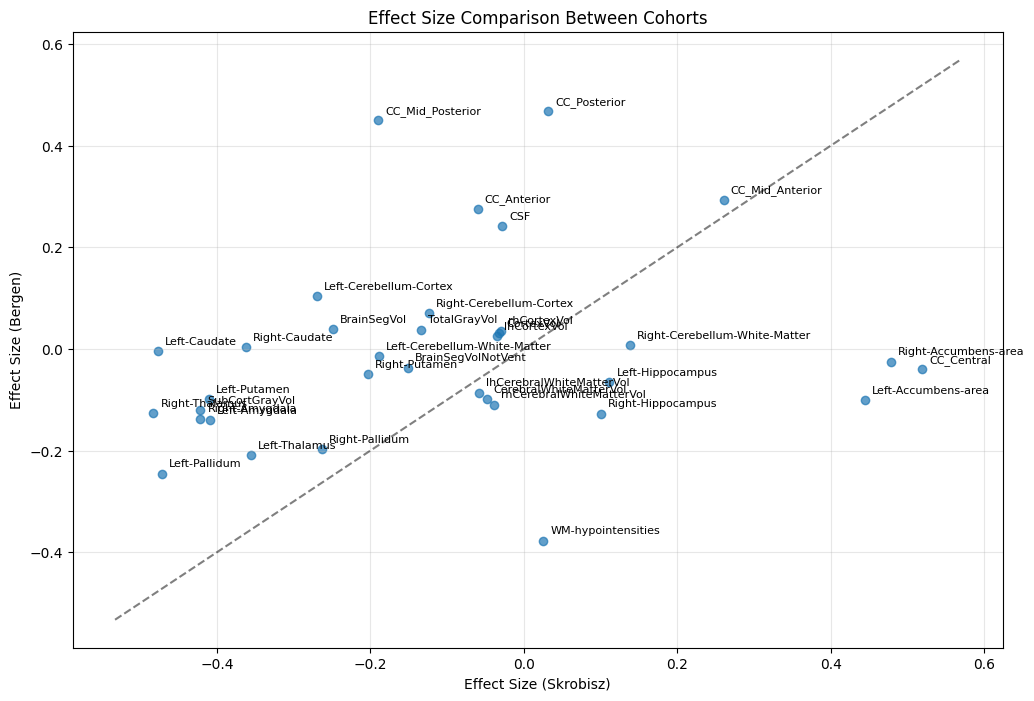

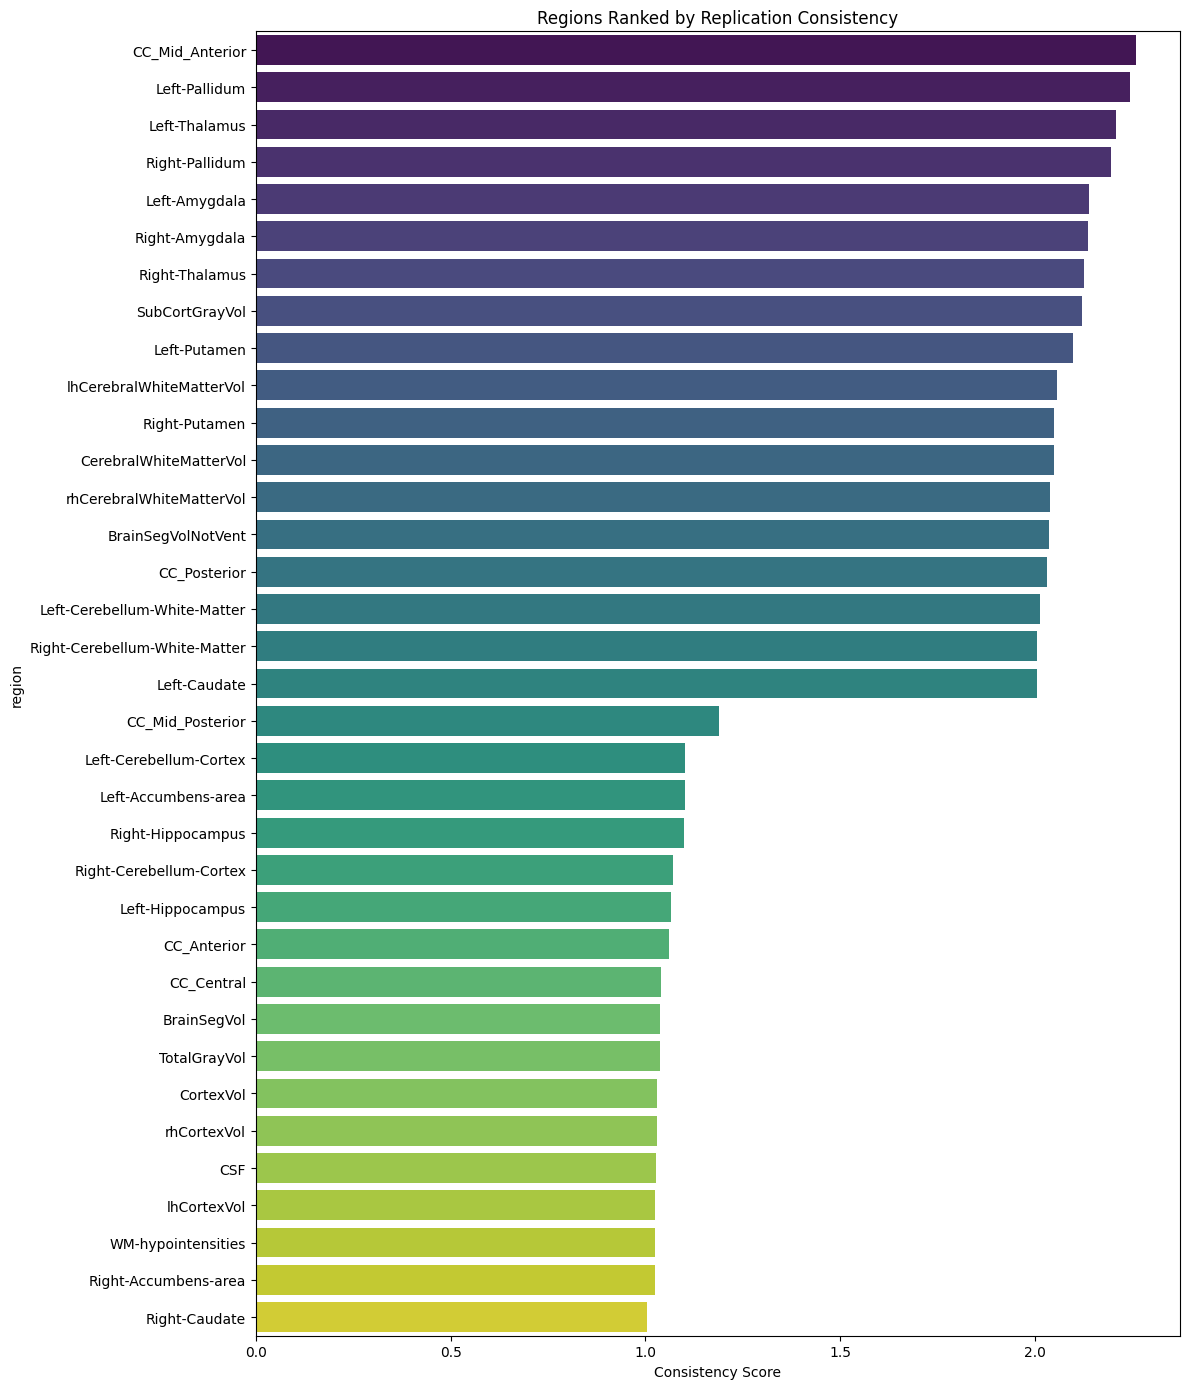

In [12]:
# Run complete analysis
results = analyze_cohorts(df_Skrobisz2022, df_results)

# Print key metrics
print(f"Effect size correlation: {results['metrics']['correlation']:.3f} (p={results['metrics']['correlation_p']:.3f})")
print(f"Sign consistency: {results['metrics']['sign_consistency']*100:.1f}%")
print(f"CI overlap rate: {results['metrics']['ci_overlap_rate']*100:.1f}%")

# Display top 5 most consistent regions
print("\nMost consistent regions:")
print(results['metrics']['most_consistent_regions'].head())
results['metrics']['most_consistent_regions']